In [1]:
import sys
import os
current_dir = os.path.dirname(os.path.abspath('./'))
if not current_dir in sys.path:
    sys.path.append(current_dir)

from decode_learning_effect import StorageManager, SessionInfo, make_session_info
import numpy as np
import matplotlib.pyplot as plt
from models import SimpleNet
import mne
from mne.datasets import multimodal
mne.set_log_level(verbose='CRITICAL')
import mneflow
import tensorflow as tf
from utils.machine_learning import one_hot_decoder, one_hot_encoder

2022-10-27 15:35:25.873697: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-27 15:35:26.222387: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-27 15:35:26.222417: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-27 15:35:26.280718: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-27 15:35:27.334145: W tensorflow/stream_executor/platform/de

In [2]:
mne.set_log_level(verbose='CRITICAL')
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

cond = raw.acqparser.get_condition(raw, None)
# get the list of condition names
condition_names = [k for c in cond for k,v in c['event_id'].items()]
epochs_list = [mne.Epochs(raw, **c) for c in cond]
epochs = mne.concatenate_epochs(epochs_list)
print(epochs.info)
epochs = epochs.pick_types(meg='grad')

X = np.array([])
Y = list()
for i, epochs in enumerate(epochs_list):
    data = epochs.get_data()
    if i == 0:
        X = data.copy()
    else:
        X = np.append(X, data, axis=0)
    Y += [i for _ in range(data.shape[0])]

Y = np.array(Y)

sample_matrix = X[0].copy()

X = np.array([X[i, epochs._channel_type_idx['grad'], :] for i, _ in enumerate(X)])


<Info | 22 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 acq_stim: 5 10.000000 500.000000 6 10.000000 500.000000
 bads: []
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 Gradiometers, 102 Magnetometers, 9 Stimulus, 1 EOG
 custom_ref_applied: False
 description: Vectorview system at BioMag
 dev_head_t: MEG device -> head transform
 dig: 21 items (3 Cardinal, 4 HPI, 14 Extra)
 events: 1 item (list)
 experimenter: neuromag
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 172.2 Hz
 meas_date: 2011-04-26 11:33:18 UTC
 meas_id: 4 items (dict)
 nchan: 316
 proj_id: 1 item (ndarray)
 proj_name: test
 projs: grad_ssp_upright.fif : PCA-v1: on, grad_ssp_upright.fif : ...
 sfreq: 600.6 Hz
 subject_info: 9 items (dict)
>


In [3]:
#Specify import options
import_opt = dict(
    savepath='./TFR',  # path where TFR files will be saved
    out_name='mne_sample_epochs',  # name of TFRecords files
    fs=600,
    input_type='trials',
    target_type='int',
    picks={'meg':'grad'},
    scale=True,  # apply baseline_scaling
    crop_baseline=True,  # remove baseline interval after scaling
    decimate=None,
    scale_interval=(0, 60),  # indices in time axis corresponding to baseline interval
    n_folds=5,  # validation set size set to 20% of all data
    overwrite=True,
    segment=False,
    test_set='holdout'
)


#write TFRecord files and metadata file to disk
meta = mneflow.produce_tfrecords((X, Y), **import_opt)

dataset = mneflow.Dataset(meta, train_batch=100)

importing from tuple
input shapes: X- (940, 204, 361) targets- (940, 1)
Preprocessing:
Scaling to interval 0.0 - 60.0
n: 940
Splitting into: 6 folds x 156
Preprocessed: (940, 1, 301, 204) (940, 1) folds: 6 x 156
Prepocessed sample shape: (1, 301, 204)
Target shape actual/metadata:  (8,) (8,)
Saving TFRecord# 0


2022-10-27 15:37:04.726216: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-27 15:37:04.726251: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-27 15:37:04.726267: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (arcolinux-machine): /proc/driver/nvidia/version does not exist
2022-10-27 15:37:04.731092: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# specify model parameters
lf_params = dict(
    n_latent=32, #number of latent factors
    filter_length=17, #convolutional filter length in time samples
    nonlin = tf.nn.relu,
    padding = 'SAME',
    pooling = 5,#pooling factor
    stride = 5, #stride parameter for pooling layer
    pool_type='max',
    model_path = import_opt['savepath'],
    dropout = .5,
    l1_scope = ["weights"],
    l1=3e-3
)

model = SimpleNet(dataset, lf_params)
model.build()

Setting reg for dmx, to l1
Built: dmx input: (None, 1, 301, 204)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 301, 32)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 301, 32)
Setting reg for fc, to l1
Built: fc input: (None, 1, 61, 32)
Input shape: (1, 301, 204)
y_pred: (None, 8)
Initialization complete!


Epoch 1/25
100/100 - 4s - loss: 4.8848 - cat_ACC: 0.1243 - val_loss: 4.5450 - val_cat_ACC: 0.1111 - 4s/epoch - 44ms/step
Epoch 2/25
100/100 - 3s - loss: 4.1839 - cat_ACC: 0.1353 - val_loss: 3.8580 - val_cat_ACC: 0.1111 - 3s/epoch - 28ms/step
Epoch 3/25
100/100 - 3s - loss: 3.4662 - cat_ACC: 0.2524 - val_loss: 3.1246 - val_cat_ACC: 0.3407 - 3s/epoch - 28ms/step
Epoch 4/25
100/100 - 3s - loss: 2.7707 - cat_ACC: 0.3893 - val_loss: 2.4631 - val_cat_ACC: 0.4889 - 3s/epoch - 26ms/step
Epoch 5/25
100/100 - 3s - loss: 2.1118 - cat_ACC: 0.5482 - val_loss: 1.8236 - val_cat_ACC: 0.6667 - 3s/epoch - 27ms/step
Epoch 6/25
100/100 - 3s - loss: 1.5461 - cat_ACC: 0.6997 - val_loss: 1.3774 - val_cat_ACC: 0.7481 - 3s/epoch - 25ms/step
Epoch 7/25
100/100 - 3s - loss: 1.1830 - cat_ACC: 0.7849 - val_loss: 1.1366 - val_cat_ACC: 0.7704 - 3s/epoch - 27ms/step
Epoch 8/25
100/100 - 3s - loss: 0.9769 - cat_ACC: 0.8328 - val_loss: 1.0118 - val_cat_ACC: 0.7556 - 3s/epoch - 31ms/step
Epoch 9/25
100/100 - 3s - loss: 

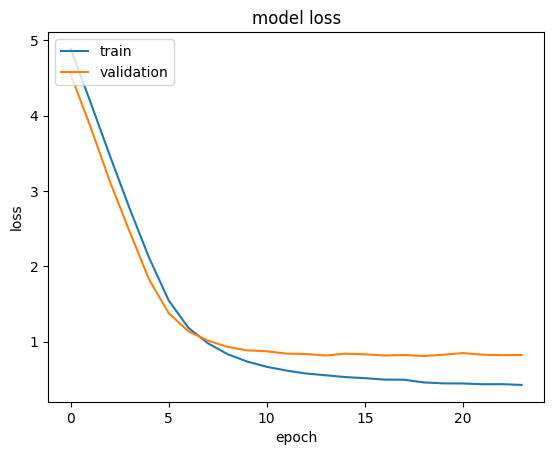

In [5]:
model.train(n_epochs=25, eval_step=100, early_stopping=5)
model.plot_hist()

In [6]:
X = mneflow.utils.scale_to_baseline(X, (0, 60), True)
X = np.expand_dims(X, 1)
X = np.transpose(X, (0, 1, 3, 2))

Scaling to interval 0.0 - 60.0


In [7]:
X.shape

(940, 1, 301, 204)

In [8]:
from mneflow.layers import LFTConv, DeMixing, Dense
model.km.save(
    '../Source/multimodal_simplenet/model.h5',
)

In [ ]:
model = tf.keras.models.load_model(
    '../Source/multimodal_simplenet/model.h5',
    custom_objects={
        'LFTConv': LFTConv,
        'DeMixing': DeMixing,
        'Dense': Dense
    }
)

In [8]:
y_pred = model.km(np.expand_dims(X[0], 0))

In [9]:
Yoh = one_hot_encoder(Y)

In [24]:
class MaximizingLabelLoss(tf.keras.losses.Loss):

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        y_true_inv = tf.cast(tf.math.logical_not(tf.cast(y_true, bool)), tf.dtypes.float32)
        y_true_val = tf.math.reduce_sum(y_true*y_pred)
        y_true = tf.squeeze(y_true)
        y_pred = tf.squeeze(y_pred)
        useful_diff = y_true_inv*y_pred - y_true_inv*y_true_val

        return tf.math.reduce_mean(useful_diff)/(1+ tf.math.reduce_std(useful_diff[:, :, 1:]))

# y_pred = np.array([-4, 8, 2, 3, 1, -5, 0, 1])


# y_pred = np.array([10, 1, 2, 3, 1, -5, 0, 1])
y_pred = np.array([[ 9.0498085 , -20.7227577 ,  -20.23577388, -2.417751  , -2.514635  ,
          0.0559853 , -6.621562  , -0.75188994]])

# y_pred = np.array([[ 9.0498085 , 0.7227577 ,  -0.23577388, -2.417751  , 2.514635  ,
#           0.0559853 , -6.621562  , -0.75188994]])

MaximizingLabelLoss()(Yohp[0], tf.expand_dims(tf.expand_dims(y_pred, 1), 1))


<tf.Tensor: shape=(), dtype=float32, numpy=-1.553995>

In [63]:

from utils.machine_learning.designer import ModelDesign, LayerDesign


class Encoder(tf.keras.Model):

    def __init__(
        self,
        decoder: mneflow.models.BaseModel,
        encoder_design: ModelDesign
    ):
        super().__init__()
        self.decoder = decoder
        self.encoder_design = encoder_design

    def call(self, inputs):
        return self.encoder_design(inputs)

    def train_step(self, data):
        X, y = data

        # loss = self.compiled_loss(y, decoder_pred, regularization_losses=self.losses)
        # print(loss)

        with tf.GradientTape() as tape:
            encoder_pred = self(y, training=True)
            decoder_pred = self.decoder.km(encoder_pred)
            decoder_pred = tf.expand_dims(tf.expand_dims(decoder_pred, 1), 1)
            loss = self.compiled_loss(y, decoder_pred, regularization_losses=self.losses)

        # # Compute gradients
        # trainable_vars = self.trainable_variables
        trainable_vars = [var for elem in self.encoder_design if hasattr(elem, 'trainable_variables') for var in elem.trainable_variables]
        gradients = tape.gradient(loss, trainable_vars)
        # # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, decoder_pred)
        # # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        # Unpack the data
        x, y = data
        # Compute predictions
        encoder_pred = self(y, training=False)
        decoder_pred = self.decoder.km(encoder_pred)
        decoder_pred = tf.expand_dims(tf.expand_dims(decoder_pred, 1), 1)
        # Updates the metrics tracking the loss
        self.compiled_loss(y, decoder_pred, regularization_losses=self.losses)
        # Update the metrics.
        self.compiled_metrics.update_state(y, decoder_pred)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}


# _, n_times, n_channels = model.input_shape
# n_classes = model.out_dim

_, n_times, n_channels = None, 301, 204
n_classes = 8


# encoder_design = ModelDesign(
#     tf.keras.Input(shape=(1, 1, n_classes,), name='input_layer'),
#     tf.keras.layers.Conv2DTranspose(1, (n_times, n_channels), kernel_regularizer='l1'),
#     LayerDesign(
#         lambda X: tf.transpose(X, (0, 3, 1, 2))
#     )
# )

encoder_design = ModelDesign(
    tf.keras.Input(shape=(1, 1, n_classes,), name='input_layer'),
    tf.keras.layers.Conv2DTranspose(10, (n_times//4, n_channels//4)),
    tf.keras.layers.Conv2DTranspose(10, (n_times//2, n_channels//2)),
    tf.keras.layers.Conv2DTranspose(1, (78, 53)),
    LayerDesign(
        lambda X: tf.transpose(X, (0, 3, 1, 2))
    )
)

encoder = Encoder(model, encoder_design)
encoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=MaximizingLabelLoss(),
    # loss='binary_focal_crossentropy',
    metrics=['acc']
)
Yohp = tf.expand_dims(tf.expand_dims(Yoh, 1), 1)
encoder.fit(
    X,
    Yohp,
    epochs=25,
    validation_split=0.2,
    shuffle=True,
)
# print(encoder.encoder_design.run_flow(np.expand_dims(Yoh, (1, 2))))

Epoch 1/25


2022-10-27 15:58:06.897298: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2340900000 exceeds 10% of free system memory.
2022-10-27 15:58:39.127392: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2340900000 exceeds 10% of free system memory.


 1/24 [>.............................] - ETA: 22:05 - loss: 2.3517 - acc: 0.0938

2022-10-27 15:59:03.486270: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2340900000 exceeds 10% of free system memory.
2022-10-27 15:59:36.123132: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2340900000 exceeds 10% of free system memory.


 2/24 [=>............................] - ETA: 21:30 - loss: 2.2518 - acc: 0.2812

2022-10-27 16:00:02.149260: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2340900000 exceeds 10% of free system memory.


24/24 [==============================] - 1707s 72s/step - loss: -2.1901 - acc: 0.9282 - val_loss: -0.0809 - val_acc: 0.3777
Epoch 2/25
24/24 [==============================] - 1644s 68s/step - loss: -2.6367 - acc: 1.0000 - val_loss: -0.0763 - val_acc: 0.3777
Epoch 3/25
 5/24 [=====>........................] - ETA: 17:36 - loss: -2.6380 - acc: 1.0000

KeyboardInterrupt: 

In [66]:
generated_data = encoder(Yohp)

In [67]:
res = model.km(generated_data).numpy()
for r, y in zip(res, Yoh):
    print(np.round(r, 2), y)

[ 123.15   21.72 -154.87  -61.39  -46.29  -12.8  -152.11  -79.31] [1. 0. 0. 0. 0. 0. 0. 0.]
[ 123.15   21.72 -154.87  -61.39  -46.29  -12.8  -152.11  -79.31] [1. 0. 0. 0. 0. 0. 0. 0.]
[ 123.15   21.72 -154.87  -61.39  -46.29  -12.8  -152.11  -79.31] [1. 0. 0. 0. 0. 0. 0. 0.]
[ 123.15   21.72 -154.87  -61.39  -46.29  -12.8  -152.11  -79.31] [1. 0. 0. 0. 0. 0. 0. 0.]
[ 123.15   21.72 -154.87  -61.39  -46.29  -12.8  -152.11  -79.31] [1. 0. 0. 0. 0. 0. 0. 0.]
[ 123.15   21.72 -154.87  -61.39  -46.29  -12.8  -152.11  -79.31] [1. 0. 0. 0. 0. 0. 0. 0.]
[ 123.15   21.72 -154.87  -61.39  -46.29  -12.8  -152.11  -79.31] [1. 0. 0. 0. 0. 0. 0. 0.]
[ 123.15   21.72 -154.87  -61.39  -46.29  -12.8  -152.11  -79.31] [1. 0. 0. 0. 0. 0. 0. 0.]
[ 123.15   21.72 -154.87  -61.39  -46.29  -12.8  -152.11  -79.31] [1. 0. 0. 0. 0. 0. 0. 0.]
[ 123.15   21.72 -154.87  -61.39  -46.29  -12.8  -152.11  -79.31] [1. 0. 0. 0. 0. 0. 0. 0.]
[ 123.15   21.72 -154.87  -61.39  -46.29  -12.8  -152.11  -79.31] [1. 0. 0. 0. 0

In [73]:
#Specify import options
import_opt = dict(
    savepath='./TFR',  # path where TFR files will be saved
    out_name='mne_sample_epochs_generated',  # name of TFRecords files
    fs=600,
    input_type='trials',
    target_type='int',
    picks={'meg':'grad'},
    scale=False,  # apply baseline_scaling
    crop_baseline=False,  # remove baseline interval after scaling
    decimate=None,
    scale_interval=(0, 60),  # indices in time axis corresponding to baseline interval
    n_folds=5,  # validation set size set to 20% of all data
    overwrite=True,
    segment=False,
    test_set='holdout'
)


#write TFRecord files and metadata file to disk
meta = mneflow.produce_tfrecords((tf.transpose(tf.squeeze(generated_data), (0, 2, 1)).numpy(), Y), **import_opt)

dataset = mneflow.Dataset(meta, train_batch=100)

importing from tuple
input shapes: X- (940, 204, 301) targets- (940, 1)
Preprocessing:
n: 940
Splitting into: 6 folds x 156
Preprocessed: (940, 1, 301, 204) (940, 1) folds: 6 x 156
Prepocessed sample shape: (1, 301, 204)
Target shape actual/metadata:  (8,) (8,)
Saving TFRecord# 0


In [79]:
model.compute_patterns(output='patterns')

Computing patterns: No path specified, using validation dataset (Default)


In [ ]:
from sp_vis import info_pick_channels

info = info_pick_channels(epochs.info, ch_names=list(
            filter(
                lambda ch_name: (
                    ch_name[-1] == '2'
                    or ch_name[-1] == '3'
                ) and 'meg' in ch_name.lower(),
                epochs.info['ch_names']
            )
        ))



In [ ]:
f1 = model.plot_patterns(info=info, sorting='output_corr')

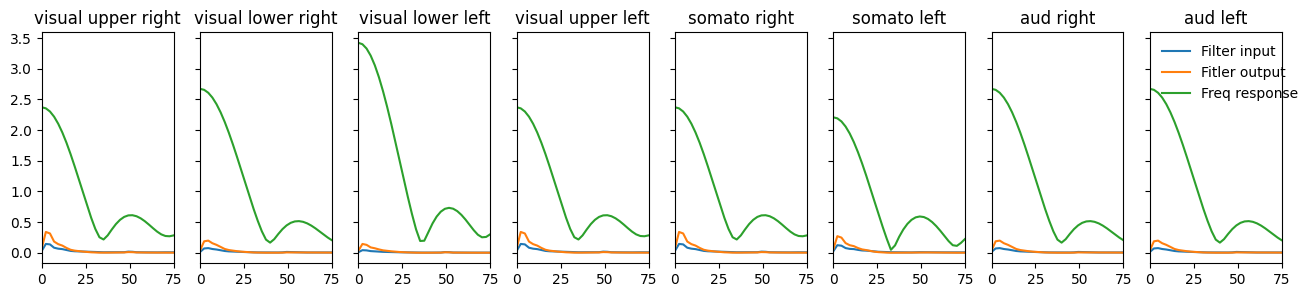

In [80]:
f2 = model.plot_spectra(
    sorting='weight_corr',
    norm_spectra='welch',
    class_names=[
        'visual upper right',
        'visual lower right',
        'visual lower left',
        'visual upper left',
        'somato right',
        'somato left',
        'aud right',
        'aud left'
    ]
)

In [81]:
model.compute_patterns(output='patterns', data_path=dataset)

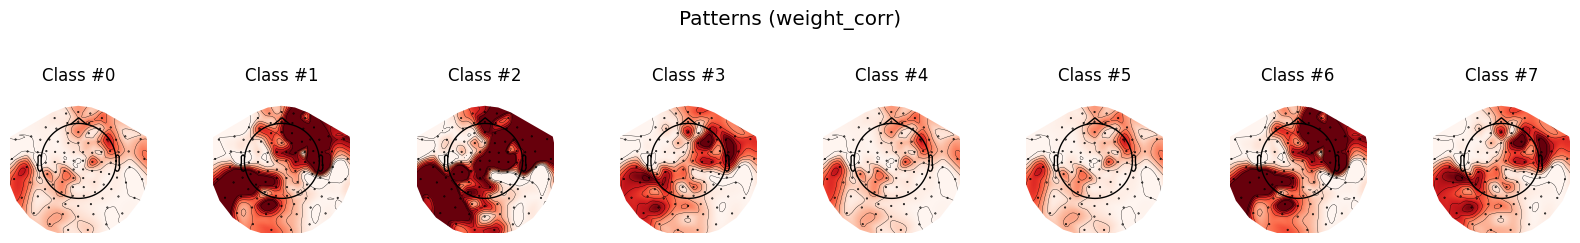

In [85]:
f1 = model.plot_patterns(info=epochs.info, sorting='weight_corr')

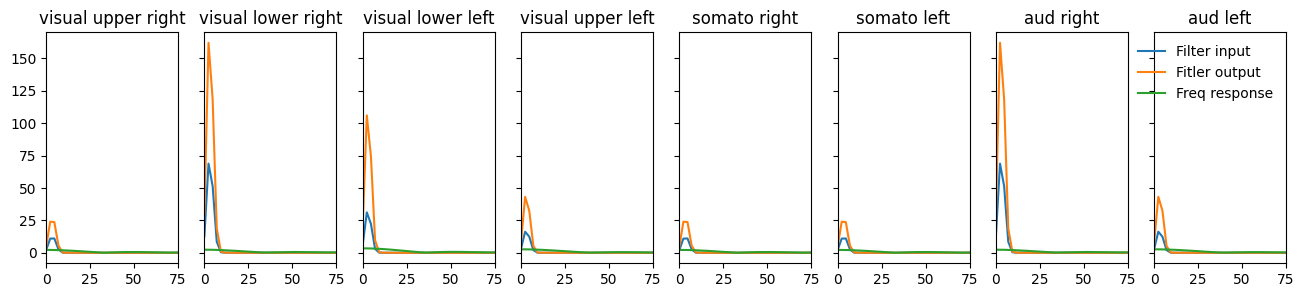

In [83]:
f2 = model.plot_spectra(
    sorting='weight_corr',
    norm_spectra='welch',
    class_names=[
        'visual upper right',
        'visual lower right',
        'visual lower left',
        'visual upper left',
        'somato right',
        'somato left',
        'aud right',
        'aud left'
    ]
)

In [93]:
from LFCNN_decoder import SpatialParameters,\
    TemporalParameters,\
    ComponentsOrder,\
    Predictions,\
    WaveForms,\
    compute_morlet_cwt,\
    compute_waveforms,\
    compute_temporal_parameters,\
    get_order
import scipy.signal as sl

def compute_patterns(model, data_path=None, *, output='patterns'):

    if not data_path:
        print("Computing patterns: No path specified, using validation dataset (Default)")
        ds = model.dataset.val
    elif isinstance(data_path, str) or isinstance(data_path, (list, tuple)):
        ds = model.dataset._build_dataset(
            data_path,
            split=False,
            test_batch=None,
            repeat=True
        )
    elif isinstance(data_path, mneflow.data.Dataset):
        if hasattr(data_path, 'test'):
            ds = data_path.test
        else:
            ds = data_path.val
    elif isinstance(data_path, tf.data.Dataset):
        ds = data_path
    else:
        raise AttributeError('Specify dataset or data path.')

    X, y = [row for row in ds.take(1)][0]

    model.out_w_flat = model.fin_fc.w.numpy()
    model.out_weights = np.reshape(
        model.out_w_flat,
        [-1, model.dmx.size, model.out_dim]
    )
    model.out_biases = model.fin_fc.b.numpy()
    model.feature_relevances = model.get_component_relevances(X, y)

    # compute temporal convolution layer outputs for vis_dics
    tc_out = model.pool(model.tconv(model.dmx(X)).numpy())

    # compute data covariance
    X = X - tf.reduce_mean(X, axis=-2, keepdims=True)
    X = tf.transpose(X, [3, 0, 1, 2])
    X = tf.reshape(X, [X.shape[0], -1])
    model.dcov = tf.matmul(X, tf.transpose(X))

    # get spatial extraction fiter weights
    demx = model.dmx.w.numpy()
    model.lat_tcs = np.dot(demx.T, X)

    kern = np.squeeze(model.tconv.filters.numpy()).T

    X = X.numpy().T
    if 'patterns' in output:
        if 'old' in output:
            model.patterns = np.dot(model.dcov, demx)
        else:
            patterns = []
            X_filt = np.zeros_like(X)
            for i_comp in range(kern.shape[0]):
                for i_ch in range(X.shape[1]):
                    x = X[:, i_ch]
                    X_filt[:, i_ch] = np.convolve(x, kern[i_comp, :], mode="same")
                patterns.append(np.cov(X_filt.T) @ demx[:, i_comp])
            model.patterns = np.array(patterns).T
    else:
        model.patterns = demx

    del X

    #  Temporal conv stuff
    model.filters = kern.T
    model.tc_out = np.squeeze(tc_out)
    model.corr_to_output = model.get_output_correlations(y)

def compute_temporal_parameters(model, *, fs=None):

    if fs is None:

        if model.dataset.h_params['fs']:
            fs = model.dataset.h_params['fs']
        else:
            print('Sampling frequency not specified, setting to 1.')
            fs = 1.

    out_filters = model.filters
    _, psd = sl.welch(model.lat_tcs, fs=fs, nperseg=fs * 2)
    finputs = psd[:, :-1]
    franges = None
    foutputs = list()
    fresponces = list()

    for i, flt in enumerate(out_filters.T):
        w, h = (lambda w, h: (w, np.abs(h)))(*sl.freqz(flt, 1, worN=fs))
        foutputs.append(np.abs(finputs[i, :] * h))

        if franges is None:
            franges = w / np.pi * fs / 2
        fresponces.append(h)

    return franges, finputs, foutputs, fresponces

def compute_waveforms(model: mneflow.models.BaseModel) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    time_courses = np.squeeze(model.lat_tcs.reshape(
        [model.specs['n_latent'], -1, model.dataset.h_params['n_t']]
    ))
    times = (1 / float(model.dataset.h_params['fs'])) *\
        np.arange(model.dataset.h_params['n_t'])
    induced = list()

    for tc in time_courses:
        ls_induced = list()

        for lc in tc:
            freqs = np.arange(1, 71)
            ls_induced.append(np.abs(compute_morlet_cwt(lc, times, freqs)))

        induced.append(np.array(ls_induced).mean(axis=0))

    return np.array(induced), times, time_courses

In [107]:


train_paths = './TFRmne_sample_epochs_train_0.tfrecord'

compute_patterns(model, train_paths)
nt = model.dataset.h_params['n_t']
time_courses = np.squeeze(model.lat_tcs.reshape([model.specs['n_latent'], -1, nt]))
times = (1 / float(model.dataset.h_params['fs'])) *\
    np.arange(model.dataset.h_params['n_t'])
patterns = model.patterns.copy()
compute_patterns(model, train_paths, output='filters')
filters = model.patterns.copy()
franges, finputs, foutputs, fresponces = compute_temporal_parameters(model)
induced, times, time_courses = compute_waveforms(model)

wf = WaveForms(time_courses.mean(1), induced, times, time_courses)
sp = SpatialParameters(patterns, filters)
tp = TemporalParameters(franges, finputs, foutputs, fresponces)
srp = ComponentsOrder(
    get_order(*model._sorting('l2')),
    get_order(*model._sorting('compwise_loss')),
    get_order(*model._sorting('weight')),
    get_order(*model._sorting('output_corr')),
    get_order(*model._sorting('weight_corr')),
)


/home/user/Projects/FingerMovementDecoder/venv/lib/python3.10/site-packages/mneflow/models.py:758: RuntimeWarning: invalid value encountered in divide
  y_true = y_true/np.linalg.norm(y_true, ord=1, axis=0)[None, :]
/home/user/Projects/FingerMovementDecoder/venv/lib/python3.10/site-packages/mneflow/models.py:991: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  order = np.array(order)
/home/user/Projects/FingerMovementDecoder/venv/lib/python3.10/site-packages/mneflow/models.py:992: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ts = np.array(ts)


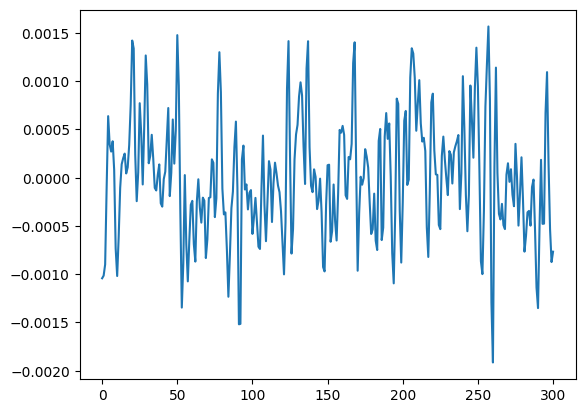

In [115]:
%matplotlib inline
plt.plot(time_courses[0, 0])

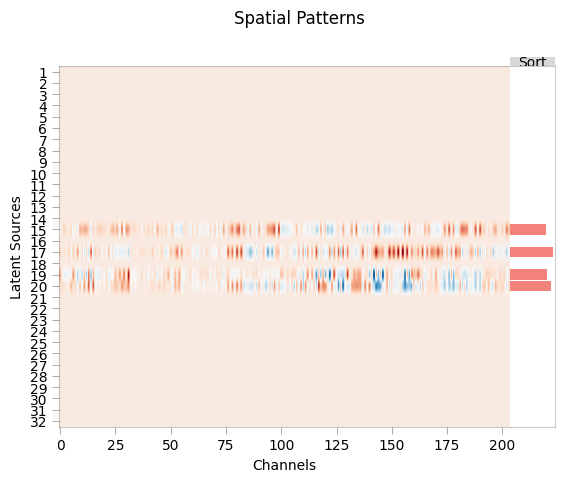

/home/user/Projects/FingerMovementDecoder/venv/lib/python3.10/site-packages/mne/io/meas_info.py:1038: RuntimeWarning: coroutine 'compute_patterns' was never awaited
  ch = ch.copy()  # shallow


In [96]:
%matplotlib qt

from sp_vis import plot_spatial_weights

plot_spatial_weights(
    sp,
    tp,
    wf,
    info,
    summarize='sumabs',
    logscale=False
)

In [116]:


train_paths = './TFRmne_sample_epochs_generated_train_0.tfrecord'

compute_patterns(model, train_paths)
nt = model.dataset.h_params['n_t']
time_courses = np.squeeze(model.lat_tcs.reshape([model.specs['n_latent'], -1, nt]))
times = (1 / float(model.dataset.h_params['fs'])) *\
    np.arange(model.dataset.h_params['n_t'])
patterns = model.patterns.copy()
compute_patterns(model, train_paths, output='filters')
filters = model.patterns.copy()
franges, finputs, foutputs, fresponces = compute_temporal_parameters(model)
induced, times, time_courses = compute_waveforms(model)

wf = WaveForms(time_courses.mean(1), induced, times, time_courses)
sp = SpatialParameters(patterns, filters)
tp = TemporalParameters(franges, finputs, foutputs, fresponces)
srp = ComponentsOrder(
    get_order(*model._sorting('l2')),
    get_order(*model._sorting('compwise_loss')),
    get_order(*model._sorting('weight')),
    get_order(*model._sorting('output_corr')),
    get_order(*model._sorting('weight_corr')),
)


/home/user/Projects/FingerMovementDecoder/venv/lib/python3.10/site-packages/mneflow/models.py:758: RuntimeWarning: invalid value encountered in divide
  y_true = y_true/np.linalg.norm(y_true, ord=1, axis=0)[None, :]
/home/user/Projects/FingerMovementDecoder/venv/lib/python3.10/site-packages/mneflow/models.py:760: RuntimeWarning: invalid value encountered in divide
  flat_feats = flat_feats/flat_div
/home/user/Projects/FingerMovementDecoder/venv/lib/python3.10/site-packages/mneflow/models.py:991: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  order = np.array(order)
/home/user/Projects/FingerMovementDecoder/venv/lib/python3.10/site-packages/mneflow/models.py:992: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lis

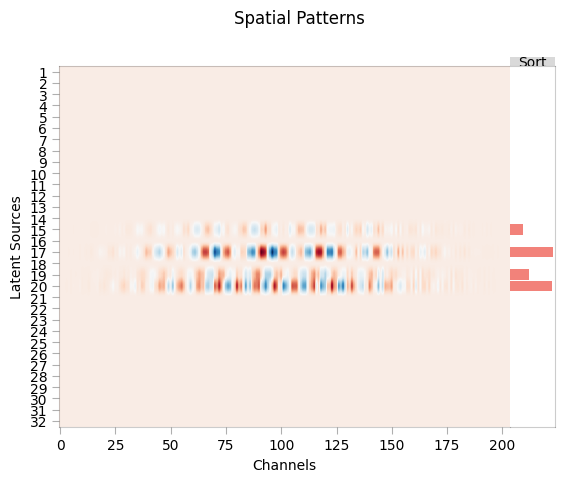

In [117]:
%matplotlib qt

from sp_vis import plot_spatial_weights

plot_spatial_weights(
    sp,
    tp,
    wf,
    info,
    summarize='sumabs',
    logscale=False
)

In [129]:
time_courses.shape

(32, 156, 301)

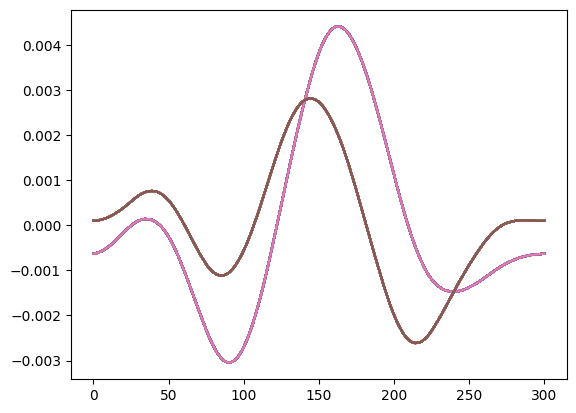

In [131]:
%matplotlib inline
plt.plot(time_courses[3, :].T)

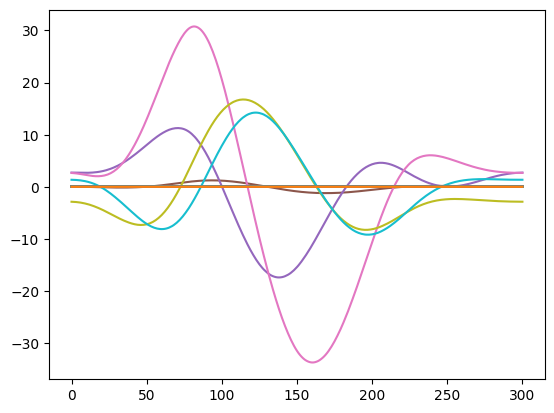

In [132]:
plt.plot(wf.evoked.T)